# Data

Let's have a look at the data first

In [1]:
import os
from pathlib import Path

input_data_path = Path(os.environ.get('INPUT_DATA_PATH', '.'))
output_data_path = Path(os.environ.get('OUTPUT_DATA_PATH', '.'))

train_file = str(input_data_path / "data_train.npz")
test_file = str(input_data_path / "data_test.npz")
prediction_file = str(output_data_path / "data_test_prediction.npz")


if not (os.path.isfile(train_file) and
        os.path.isfile(test_file)):
    if not os.path.isfile("input_public_data.zip"):
        !wget https://codalab.coresearch.club/my/datasets/download/37304c34-1d4a-4f43-bcb2-1fdeb37c5cba -O input_public_data.zip
    !unzip -n input_public_data.zip

In [2]:
import numpy as np

In [3]:
data_real = np.load(train_file, allow_pickle=True)

# This is the calorimeter response:
energy = data_real['EnergyDeposit']

# These are the quantities we want to predict
momentum = data_real['ParticleMomentum'][:,:2]
coordinate = data_real['ParticlePoint'][:,:2]

In [4]:
print('energy.shape:', energy.shape)
print('momentum.shape:', momentum.shape)
print('coordinate.shape:', coordinate.shape)

energy.shape: (9916, 30, 30)
momentum.shape: (9916, 2)
coordinate.shape: (9916, 2)


So, we have images of 30x30 pixels and we want to predict 4 numbers for each of them: x, y, px and py.

Let's have a look at some of the images

In [5]:
import matplotlib.pyplot as plt

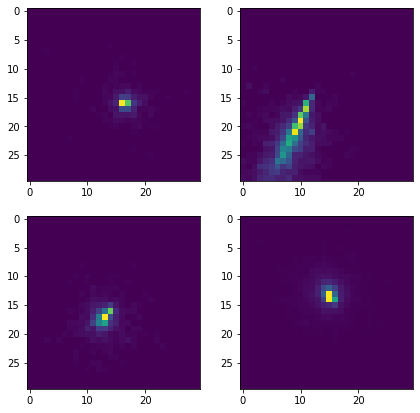

In [6]:
plt.figure(figsize=(7, 7))
plt.subplot(221)
plt.imshow(energy[5])
plt.subplot(222)
plt.imshow(energy[50])
plt.subplot(223)
plt.imshow(energy[500])
plt.subplot(224)
plt.imshow(energy[5000]);

It's also worth knowing how the targets are distributed:

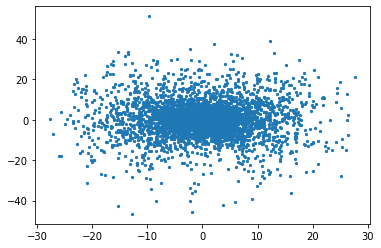

In [7]:
plt.scatter(*momentum.T, s=5);

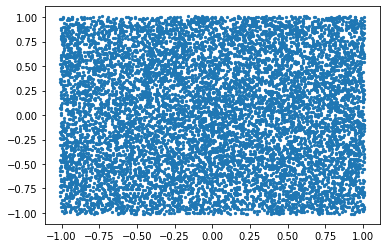

In [8]:
plt.scatter(*coordinate.T, s=5);

Naive approach: can we predict the coordinates from the center of mass position of the calorimeter response?

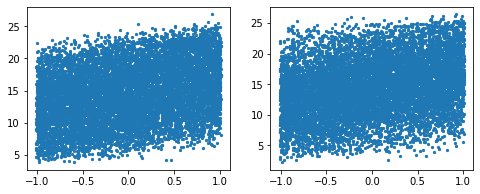

In [9]:
energy_density = energy / energy.sum(axis=(1, 2), keepdims=True)

cell_coords = np.stack([*np.meshgrid(
    np.arange(energy.shape[1]),
    np.arange(energy.shape[2])
)], axis=-1)[None,...]

center_of_mass = (energy_density[...,None] * cell_coords).sum(axis=(1, 2))

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(coordinate[:,0], center_of_mass[:,0], s=5)
plt.subplot(122)
plt.scatter(coordinate[:,1], center_of_mass[:,1], s=5);

Looks like the correlation isn't too strong. Maybe higher moments would give us a better picture, but we'll leave such experiments to you.

# Solution

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim

from IPython.display import clear_output
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [11]:
device = torch.device('cuda:0')
# device = torch.device('cpu:0')
device

device(type='cuda', index=0)

### Data Preparation

In [12]:
X = energy[:,None,...] # adding Channels dimension
Y = np.concatenate([coordinate, momentum], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(8924, 1, 30, 30) (8924, 4) (992, 1, 30, 30) (992, 4)


In [13]:
def make_torch_dataset(X, Y, batch_size, shuffle=True):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    ds = utils.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        ds, batch_size=batch_size,
        pin_memory=True, shuffle=shuffle
    )

BATCH_SIZE = 1024

ds_train = make_torch_dataset(X_train, Y_train, BATCH_SIZE)
ds_val = make_torch_dataset(X_val, Y_val, BATCH_SIZE, shuffle=False)

In [14]:
def metric_relative_mse(y_true, y_pred):
    return (
        (y_true - y_pred).pow(2).mean(dim=0) / y_true.pow(2).mean(dim=0)
    )

def metric_relative_mse_total(y_true, y_pred):
    return metric_relative_mse(y_true, y_pred).sum()

In [15]:
loss_fn = torch.nn.MSELoss().to(device)

def run_training(regressor, epochs=5, learning_rate = 1e-3):
    opt = optim.Adam(regressor.parameters(), lr=learning_rate)
    losses_train = []
    losses_val = []
    metrics_train = []
    metrics_val = []
    per_component_metrics_train = []
    per_component_metrics_val = []

    for epoch in tqdm(range(epochs)):
        for batch_X, batch_Y in ds_train:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            pred = regressor(batch_X)
                        
            loss = loss_fn(pred, batch_Y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses_train.append(loss.item())
            metrics_train.append(
                metric_relative_mse_total(batch_Y, pred).item()
            )

            per_component_metrics_train.append(
                metric_relative_mse(batch_Y, pred).detach().cpu().numpy()
            )

        avg_loss, avg_metrics, avg_per_component_metrics = [], [], []
        for batch_X, batch_Y in ds_val:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            pred = regressor(batch_X)
            loss = loss_fn(pred, batch_Y)

            avg_loss.append(loss.item())
            avg_metrics.append(
                metric_relative_mse_total(batch_Y, pred).item()
            )
            avg_per_component_metrics.append(
                metric_relative_mse(batch_Y, pred).detach().cpu().numpy()
            )
        losses_val.append(np.mean(avg_loss))
        metrics_val.append(np.mean(avg_metrics))
        per_component_metrics_val.append(
            np.mean(avg_per_component_metrics, axis=0)
        )


        clear_output()
        plt.figure(figsize=(18, 4.5))

        plt.subplot(131)

        plt.title("Loss")
        plt.plot(losses_train, label='train')
        plt.plot(
            np.linspace(0, len(losses_train), len(losses_val), endpoint=False),
            losses_val, label='val'
        )
        plt.legend()

        plt.subplot(132)

        plt.title("Metric (per component)")
        ms_train = np.array(per_component_metrics_train).T
        ms_val = np.array(per_component_metrics_val).T
        for i, (m_train, m_val, color) in enumerate(zip(ms_train,
                                                        ms_val,
                                                        plt.rcParams['axes.prop_cycle'])):
            plt.plot(m_train, label=f'train (component {i})', c=color['color'])
            plt.plot(
                np.linspace(0, len(m_train), len(m_val), endpoint=False),
                m_val, '--', label=f'val (component {i})', c=color['color']
            )
        plt.legend()

        plt.subplot(133)

        plt.title("Metric (total)")
        plt.plot(metrics_train, label='train')
        plt.plot(
            np.linspace(0, len(metrics_train), len(metrics_val), endpoint=False),
            metrics_val, label='val'
        )
        plt.legend()
        plt.show()
        
    # Get final 
    return [metrics_train, per_component_metrics_train], [metrics_val, per_component_metrics_val]

In [16]:
# Disclaimer: this might not be the best architecture for the task

class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=3,
                               kernel_size=7)
        self.pool = nn.MaxPool2d((4, 4))
        self.conv2 = nn.Conv2d(in_channels=3,
                               out_channels=8,
                               kernel_size=4)

        self.fc1 = nn.Linear(3 * 3 * 8, 32)
        self.fc2 = nn.Linear(32, 2 + 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.reshape(len(x), -1)

        x = F.leaky_relu(self.fc1(x))

        return self.fc2(x)

In [17]:
class ConvBlock(nn.Module):
    def __init__(self,
                 in_channels,     # <== number of input channels to the 1st convolution
                 interm_channels, # <== outputs of the 1st / inputs of the 2nd convolution
                 out_channels,    # <== outputs of the 2nd convolution
                 use_batchnorm,   # <== whether we'll use batchnorm
                 initialization): # <== function that'll initialize the weights
        # First we run the base class constructor
        super(ConvBlock, self).__init__()

        # And then define all the layers used within a block
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=interm_channels,
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=interm_channels,
                               out_channels=out_channels,
                               kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.use_batchnorm = use_batchnorm
        if use_batchnorm:
            self.bn1 = nn.BatchNorm2d(interm_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)

        # If initialization function provided, call it on the weights of the model
        if initialization is not None:
            initialization(self.conv1.weight)
            initialization(self.conv2.weight)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = F.relu(x)

        x = self.pool(x)
        return x

# The model itself:
class Net(nn.Module):
    def __init__(self, use_batchnorm, initialization):
        super(Net, self).__init__()

        # Convolutional layers:                                         # 3x32x32 (Channels x height x width)
        self.conv1 = ConvBlock(1, 8, 16, use_batchnorm, initialization) # -> 8x32x32 -> 16x32x32 -> 16x16x16
        self.conv2 = ConvBlock(16, 16, 32, use_batchnorm, initialization) # -> 16x16x16 -> 32x16x16 -> 32x8x8
        self.conv3 = ConvBlock(32, 32, 64, use_batchnorm, initialization)

        # Fully connected layers:
        self.fc1 = nn.Linear(1568, 512)
        #self.drop_layer1 = nn.Dropout(p = 0.2)
        self.fc2 = nn.Linear(512, 128)
        #self.drop_layer2 = nn.Dropout(p = 0.1)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 4)


        
        
        # If initialization function provided, call it on the weights of the model
        if initialization is not None:
            initialization(self.fc1.weight)
            initialization(self.fc2.weight)
            initialization(self.fc3.weight)
            #initialization(self.fc4.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = x.reshape(len(x), -1)
        x = F.relu(self.fc1(x))
        #x = self.drop_layer1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = self.drop_layer2(x)
        x = self.fc4(x)
        return x

In [18]:
# Training parameters
learning_rate = 1.5e-3
epochs = 70

# Regularisation configuration 
config = he_normal_init_with_batchnorm=dict(
        use_batchnorm=True,
     initialization=(lambda w: torch.nn.init.kaiming_normal_(w, nonlinearity='relu'))
)


regressor = Net(**config).to(device)



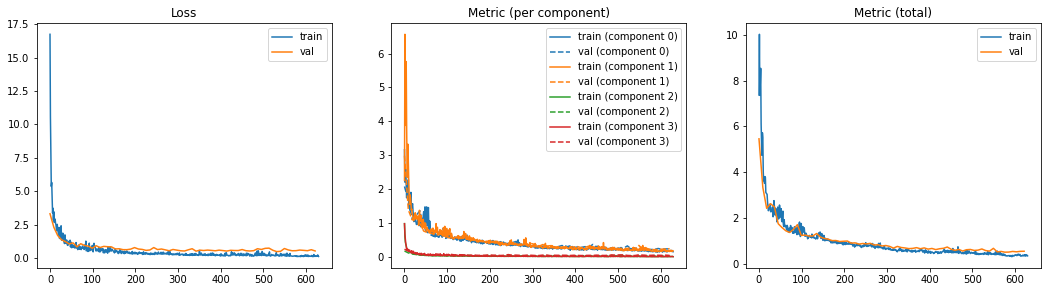

100%|██████████| 70/70 [01:41<00:00,  1.46s/it]

100%|██████████| 70/70 [01:41<00:00,  1.45s/it]

[7.37060546875, 10.025172233581543, 7.352756500244141, 7.852417469024658, 8.536974906921387, 6.111485004425049, 5.270106792449951, 4.733173847198486, 5.718783855438232, 5.501757621765137, 3.996594190597534, 3.6177403926849365, 3.719008445739746, 3.506525993347168, 3.8020706176757812, 3.7636606693267822, 3.108617067337036, 3.0800318717956543, 3.0577025413513184, 3.025113105773926, 2.7012884616851807, 2.4974937438964844, 2.3100156784057617, 2.3689565658569336, 2.5103518962860107, 2.5875587463378906, 2.5405352115631104, 2.2903270721435547, 2.2591960430145264, 2.3065133094787598, 2.3640105724334717, 2.460690975189209, 2.4789133071899414, 2.0454447269439697, 2.1585583686828613, 2.752154588699341, 2.53222393989563, 2.1354713439941406, 2.1253838539123535, 2.4218337535858154, 2.3210601806640625, 2.056365966796875, 1.8227641582489014, 2.0971574783325195, 2.4703822135925293, 2.4498894214630127, 1.9480829238891602, 2.131063938140869, 2.559998035430908, 2.4149796962738037, 2.0347952842712402, 2.06

In [19]:
# Training 
train_metric, val_metric = run_training(regressor, epochs = epochs, learning_rate = learning_rate)
print(train_metric[0], val_metric[0])

### Def scoring - cross-check with scoring given on Coop page 

In [20]:
def scoring_function(solution, predict):
    score = 0.
    
    ParticlePoint_sol = solution[:, :2]
    ParticleMomentum_sol = solution[:, 2:]
    
    ParticlePoint_pred = predict[:, :2]
    ParticleMomentum_pred = predict[:, 2:]
    
    score += np.sum(np.square(ParticleMomentum_sol - ParticleMomentum_pred).mean(axis=0) / np.square(ParticleMomentum_sol).mean(axis=0))
    score += np.sum(np.square(ParticlePoint_sol - ParticlePoint_pred).mean(axis=0) / np.square(ParticlePoint_sol).mean(axis=0))
    return score

In [21]:
prediction_val = regressor(torch.tensor(X_val, device=device).float()).cpu()
print(scoring_function(Y_val, prediction_val.detach().numpy()))

0.5382468542874629


### Compress test files

In [0]:
data_test = np.load(test_file, allow_pickle=True)
X_test = data_test['EnergyDeposit'][:,None,...]
prediction_test = regressor(torch.tensor(X_test, device=device).float()).cpu()
coordinate_test, momentum_test = (
    prediction_test.detach().numpy()[:, :2],
    prediction_test.detach().numpy()[:, 2:],
)

np.savez_compressed(prediction_file,
                    ParticlePoint=coordinate_test,
                    ParticleMomentum=momentum_test)